In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

In [2]:
base_path = "../../data/simulations/processed/"
data_paths = ["mixtral_8x7b_data.csv", "dolphin_mixtral_data.csv", "gpt_4o_mini_data.csv"]
model_paths = ["mixtral", "dm", "gpt"]

In [3]:
effect_sizes = []

for p, path in enumerate(data_paths):
    df = pd.read_csv(base_path + path)

    # timesteps start from 1
    df.loc[:, "t"] = df.loc[:, "t"]+1

    # add a column to indicate whether the row is a discussion (t>1) or initial message (t=1) 
    df["is_discussion"] = (df["t"] != 1).astype(int)
    df["is_responder"] = (df["is_initiator"] != 1).astype(int)

    # Add x_0 column for anchoring effect
    for i in range(len(df)):
        if df.loc[i, "t"] == 1:
            df.loc[i, "x_0"] = df.loc[i, "x_j"]

        else:
            df.loc[i, "x_0"] = df.loc[i-2, "x_0"]

    # convert to numpy
    delta_x = df['dx'].to_numpy() # opinion change from agent i (t to t+1)
    x_i = df['x_i'].to_numpy() # opinion of agent i at time t
    H_i = df["H_i"].to_numpy() # uncertainty of agent i at time t
    x_j = df['x_j'].to_numpy() # opinion of agent j at time t
    H_j = df['H_j'].to_numpy() # uncertainty of agent j at time t
    t_data = df['t'].to_numpy() # time step
    d_data = df['delta'].to_numpy() # question framing (-1 or 1)
    is_climate = df['is_climate'].to_numpy() # binary indicator for climate question
    is_ai = df['is_ai'].to_numpy() # binary indicator for AI question
    is_gwd = df['is_gwd'].to_numpy() # binary indicator for wealth distribution question
    is_discussion = df['is_discussion'].to_numpy() # binary indicator for discussion (1) or initial message (0)
    x_0 = df['x_0'].to_numpy()
    is_responder = df['is_responder'].to_numpy()

    trace = az.from_netcdf("../../data/bayesian_inference/raw/traces/full_model_trace_" + model_paths[p] + "_all.nc")

    # extract posterior samples
    alpha = trace.posterior["alpha"].values.flatten()

    # extract mean
    tau = trace.posterior["tau"].values.flatten().mean()

    # predictor and observable 
    predictor = np.exp(-t_data/tau.mean())*(x_j - x_i)
    observable = delta_x

    # calculate effect size distribution of alpha
    effect_size_alpha = alpha * predictor.std() / observable.std()
    effect_sizes.append(effect_size_alpha)


    # for beta_topic
    beta_t = trace.posterior["beta_t"].values.flatten()
    b0 = trace.posterior['b'][...,0].values.flatten().mean()
    b1 = trace.posterior['b'][...,1].values.flatten().mean()
    b2 = trace.posterior['b'][...,2].values.flatten().mean()

    b = b0*is_climate + b1*is_ai + b2*is_gwd
    n = d_data*b 
    predictor = n - x_i

    effect_size_beta_t = beta_t * (predictor.std() / observable.std())
    effect_sizes.append(effect_size_beta_t)

    # for beta_agree
    beta_a = trace.posterior["beta_a"].values.flatten()
    a  = trace.posterior['a'].values.flatten().mean()
    predictor = a - x_i

    effect_size_beta_a = beta_a * (predictor.std() / observable.std())
    effect_sizes.append(effect_size_beta_a)


    # for beta_anchor
    beta_c = trace.posterior["beta_c"].values.flatten()
    predictor = (x_0 - x_i)* is_responder

    effect_size_beta_c = beta_c * (predictor.std() / observable.std()) 
    effect_sizes.append(effect_size_beta_c)

    print(len(effect_sizes))

4
8
12


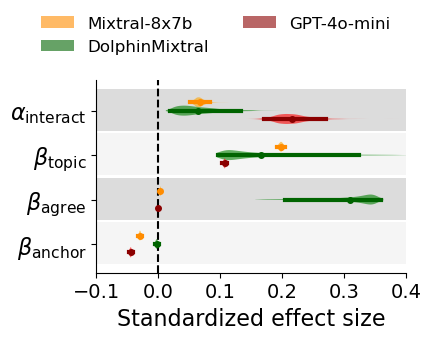

In [ ]:
params = ["alpha", "beta_t", "beta_a", "beta_c"]
param_labels = [r"$\alpha_{\text{interact}}$",  r"$\beta_{\text{topic}}$", r"$\beta_{\text{agree}}$", r"$\beta_{\text{anchor}}$"]
llms = ["LLM 1", "LLM 2", "LLM 3"]
llm_labels = ["Mixtral-8x7b", "DolphinMixtral", "GPT-4o-mini"]

posterior = {
    "LLM 1": {"alpha": effect_sizes[0],
              "beta_t":  effect_sizes[1],
              "beta_a": effect_sizes[2],
              "beta_c": effect_sizes[3]},
    "LLM 2": {"alpha": effect_sizes[4],
              "beta_t":  effect_sizes[5],
              "beta_a": effect_sizes[6],
              "beta_c": effect_sizes[7]},
    "LLM 3": {"alpha": effect_sizes[8],
              "beta_t":  effect_sizes[9],
              "beta_a": effect_sizes[10],
              "beta_c": effect_sizes[11]},
}

# Color settings
violin_colors = {"LLM 1": "orange", "LLM 2": "green", "LLM 3": "red"}
hdi_colors    = {"LLM 1": "darkorange", "LLM 2": "darkgreen", "LLM 3": "darkred"}

# Y‑positions: one group per parameter
base_y = np.linspace(0, 4, 4)[::-1]  # beta bottom, alpha top
offsets = {"LLM 1": +0.25, "LLM 2": 0.0, "LLM 3": -0.25}

fig, ax = plt.subplots(figsize=(4, 2.5))

for p_idx, param in enumerate(params):
    for llm in llms:
        draws = posterior[llm][param]
        y_pos = base_y[p_idx] + offsets[llm]
        
        # Violin
        parts = ax.violinplot(draws, positions=[y_pos], vert=False,
                              widths=0.3, showmeans=False, showextrema=False,
                              showmedians=False)
        parts["bodies"][0].set_facecolor(violin_colors[llm])
        parts["bodies"][0].set_edgecolor("none")
        parts["bodies"][0].set_alpha(0.6)
        
        # HDI & mean
        hdi_low, hdi_high = az.hdi(draws, hdi_prob=0.95)
        mean = draws.mean()
        ax.plot([hdi_low, hdi_high], [y_pos, y_pos], color=hdi_colors[llm], lw=3)
        ax.plot(mean, y_pos, marker="o", color=hdi_colors[llm], markersize=4)

        rect = Rectangle(
        (-2, base_y[p_idx]-0.6),   # bottom left corner (x, y)
        5, 1.25,     # width, heigh
        facecolor='gainsboro' if p_idx%2 == 0 else 'whitesmoke',  # shaded fill
        zorder=-100
        )

        ax.add_patch(rect)


# Aesthetics
ax.axvline(0, linestyle="--", color="black", zorder=-2, lw=1.5)
ax.set_yticks(base_y)
ax.set_yticklabels(param_labels)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=16)

ax.set_xlabel(r"Standardized effect size", fontsize=16)
ax.spines[["top", "right"]].set_visible(False)
ax.set_xlim(-0.1, 0.4)

# Legend
handles = [Patch(facecolor=hdi_colors[llm], edgecolor="none",
                 alpha=0.6, label=llm_labels[i]) for i, llm in enumerate(llms)]
ax.legend(handles=handles, frameon=False, fontsize=12, loc=(-0.2, 1.1), ncols=2)
plt.savefig("../../plots/figure_3.png", dpi=400, bbox_inches='tight')
plt.show()